Dataset loaded successfully: (14634, 66)
Target variable 'early_sexual_debut' found in dataset

Starting Phase 3.1: Data Splitting...
PHASE 3.1: DATA SPLITTING STRATEGY
Dataset after removing missing targets: (14634, 66)

COLUMNS EXCLUDED FROM FEATURES:
  ID variables: ['caseid', 'household_id', 'v001', 'v002']
  Leakage variables: ['v525', 'v512', 'v511', 'v212']
  Target variable: ['early_sexual_debut']
  Total excluded: 9
✓ Confirmed: All problematic variables excluded from features
✓ Total features available: 61

FEATURE SET VERIFICATION:
  Feature matrix shape: (14634, 61)
  Target vector shape: (14634,)
  Sample feature columns: ['v012', 'v013', 'v101', 'v102', 'v106', 'v107', 'v130', 'v190', 'v191', 'hv270']

TARGET VARIABLE DISTRIBUTION:
  Late debut (0): 7,919 (54.1%)
  Early debut (1): 6,715 (45.9%)
Minority class proportion: 45.9%

Implementing cluster-aware data splitting using v001
Total clusters: 500
Average cluster size: 29.3

DATA SPLIT SUMMARY:
Split      Size       Ea

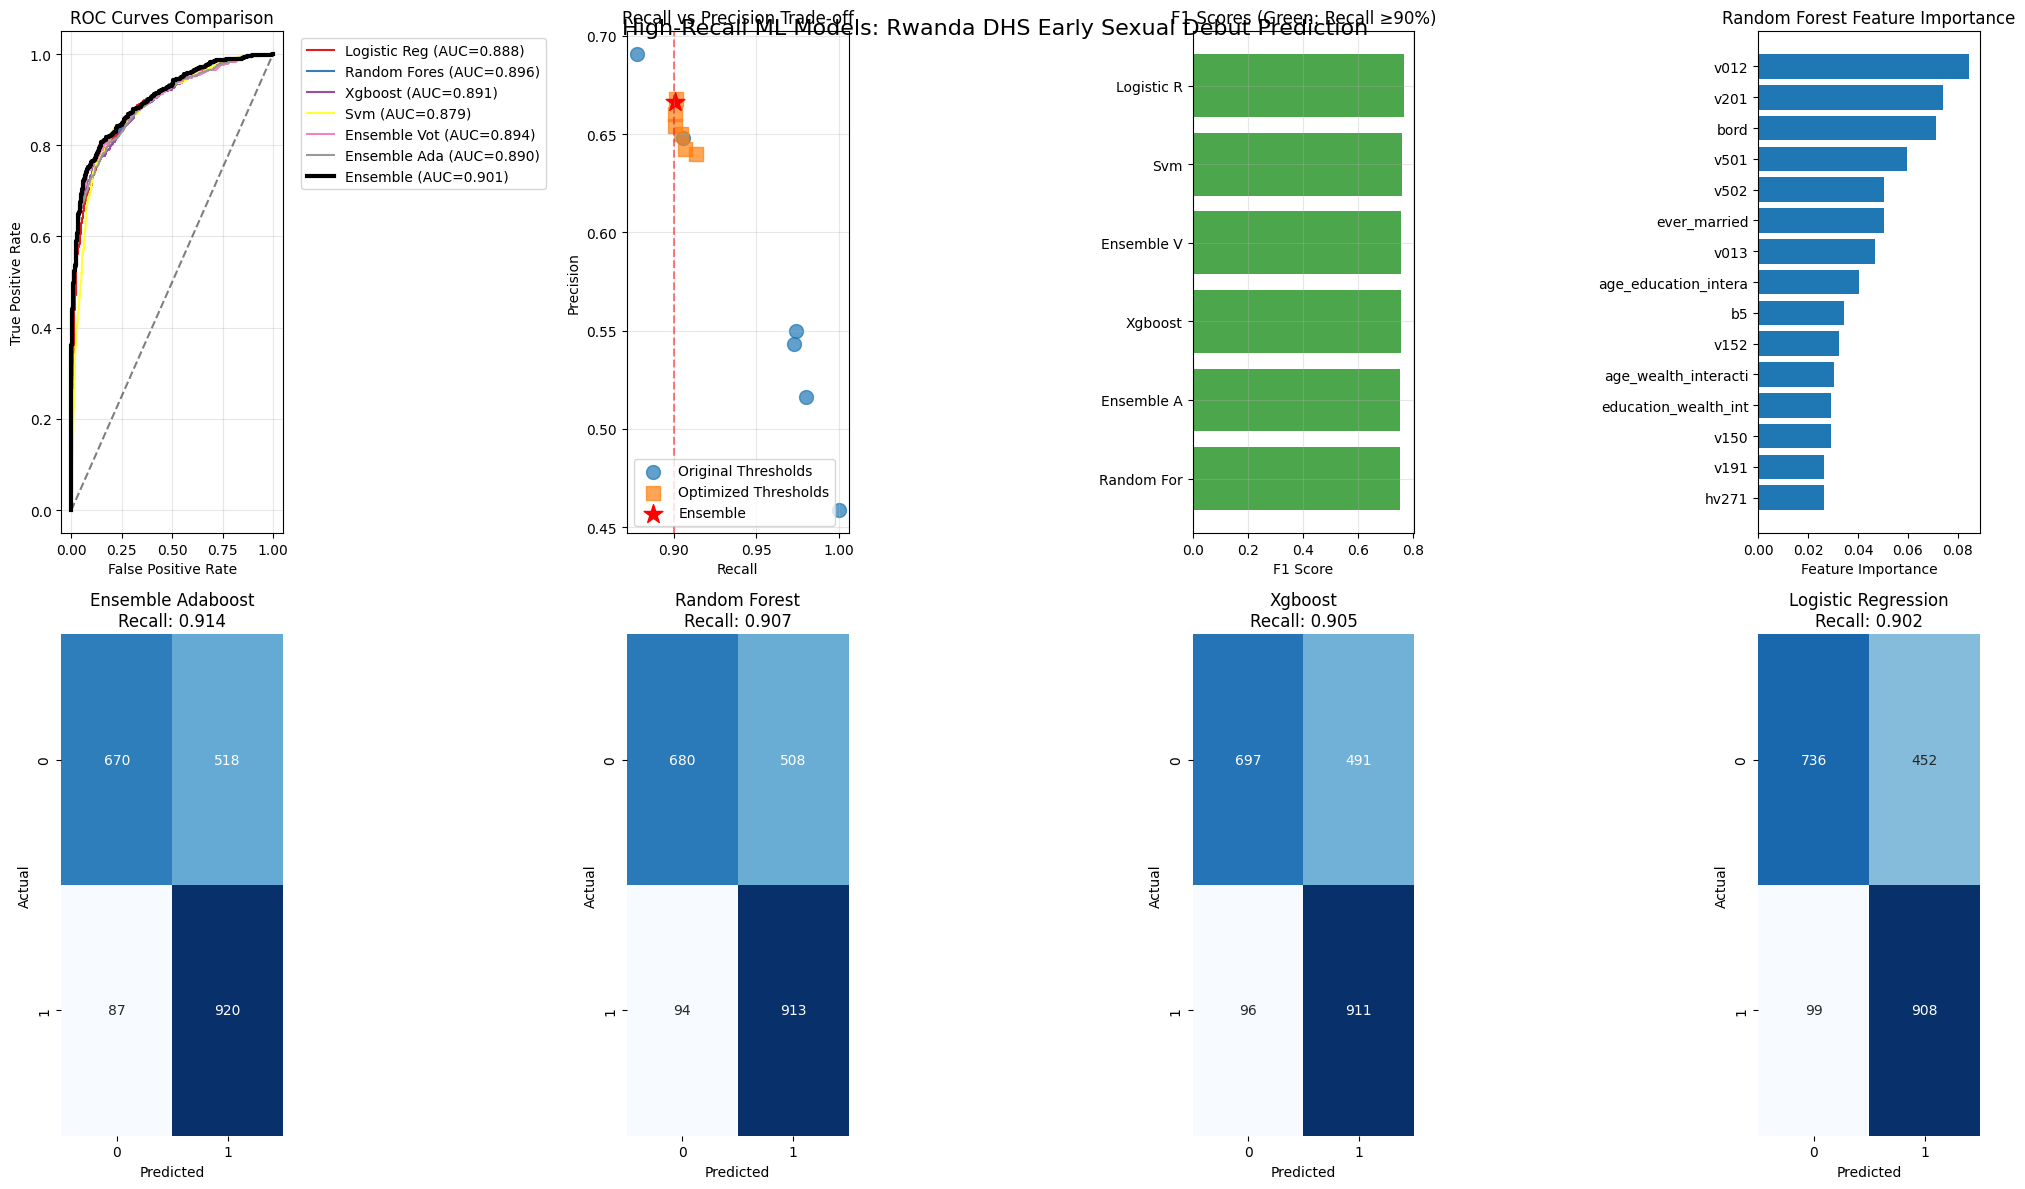

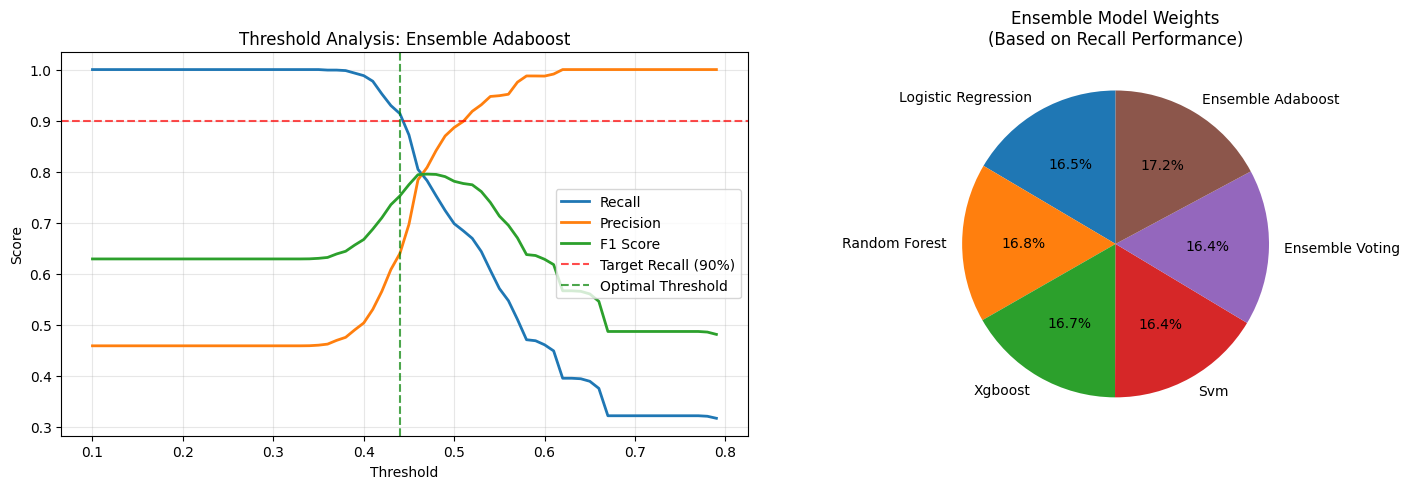


HIGH-RECALL MODEL DEVELOPMENT COMPLETE!

 FINAL RESULTS SUMMARY:
✓ Total models trained: 6
✓ Models achieving ≥90% recall: 6/6
✓ Best high-recall model: Ensemble Adaboost
  - Recall: 0.9136 (91.4%)
  - Precision: 0.6398
  - F1 Score: 0.7526
  - Cases missed: 8.6%

🎯 TARGET ACHIEVEMENT:
  🟡 GOOD: 90-95% recall achieved!

 ENSEMBLE PERFORMANCE:
  - Ensemble Recall: 0.9007 (90.1%)
  - Cases missed: 9.9%

 READY FOR DEPLOYMENT:
  - Models optimized for Rwanda's public health needs
  - High recall prioritizes identifying at-risk adolescents
  - Ready for Phase 4: Final Testing and Validation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Algorithm imports
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

def prepare_model_data(df, target_col='early_sexual_debut', test_size=0.15, val_size=0.15, random_state=42):
    """
    Phase 3.1: Data Splitting Strategy - CORRECTED to ensure target exclusion
    """
    
    print("="*80)
    print("PHASE 3.1: DATA SPLITTING STRATEGY")  
    print("="*80)
    
    # Remove rows with missing target
    df_clean = df.dropna(subset=[target_col]).copy()
    print(f"Dataset after removing missing targets: {df_clean.shape}")
    
    # CRITICAL: Define all columns to exclude from features
    id_columns = ['caseid', 'household_id', 'v001', 'v002']
    
    # Known leakage variables (must be excluded)
    leakage_variables = ['v525', 'v512', 'v511', 'v212']  # Age at first sex, marriage, cohabitation, birth
    
    # Target variable (must be excluded)
    target_variables = [target_col]
    
    # Complete exclusion list
    exclude_columns = id_columns + leakage_variables + target_variables
    
    print(f"\nCOLUMNS EXCLUDED FROM FEATURES:")
    print(f"  ID variables: {id_columns}")
    print(f"  Leakage variables: {leakage_variables}")
    print(f"  Target variable: {target_variables}")
    print(f"  Total excluded: {len(exclude_columns)}")
    
    # Create feature column list
    feature_columns = [col for col in df_clean.columns 
                      if col not in exclude_columns]
    
    # VERIFICATION: Ensure target and leakage variables are not in features
    problematic_vars = [var for var in exclude_columns if var in feature_columns]
    if problematic_vars:
        raise ValueError(f"CRITICAL ERROR: Problematic variables found in features: {problematic_vars}")
    
    print(f"✓ Confirmed: All problematic variables excluded from features")
    print(f"✓ Total features available: {len(feature_columns)}")
    
    # Prepare features (X) and target (y) separately
    X = df_clean[feature_columns].copy()
    y = df_clean[target_col].copy()
    
    # DOUBLE VERIFICATION: Check matrices
    print(f"\nFEATURE SET VERIFICATION:")
    print(f"  Feature matrix shape: {X.shape}")
    print(f"  Target vector shape: {y.shape}")
    print(f"  Sample feature columns: {feature_columns[:10]}")
    
    # Final assertion check
    assert target_col not in X.columns, f"CRITICAL ERROR: {target_col} found in feature matrix!"
    assert not any(var in X.columns for var in leakage_variables), "CRITICAL ERROR: Leakage variables in features!"
    
    # Handle any remaining missing values in features
    missing_features = X.isnull().sum()
    if missing_features.sum() > 0:
        print(f"\nHandling missing values in {(missing_features > 0).sum()} features...")
        from sklearn.impute import SimpleImputer
        
        # Separate numeric and categorical features
        numeric_features = X.select_dtypes(include=[np.number]).columns
        categorical_features = X.select_dtypes(exclude=[np.number]).columns
        
        if len(numeric_features) > 0:
            numeric_imputer = SimpleImputer(strategy='median')
            X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])
        
        if len(categorical_features) > 0:
            cat_imputer = SimpleImputer(strategy='most_frequent')
            X[categorical_features] = cat_imputer.fit_transform(X[categorical_features])
        
        print(f"✓ Missing values handled")
    
    # Convert target to integer if needed
    y = y.astype(int)
    
    # Class distribution analysis
    class_counts = pd.Series(y).value_counts().sort_index()
    class_props = class_counts / len(y)
    
    print(f"\nTARGET VARIABLE DISTRIBUTION:")
    for class_val, count in class_counts.items():
        prop = class_props[class_val]
        label = "Early debut" if class_val == 1 else "Late debut"
        print(f"  {label} ({class_val}): {count:,} ({prop:.1%})")
    
    # Calculate stratification parameters
    minority_class_prop = class_props.min()
    print(f"Minority class proportion: {minority_class_prop:.1%}")
    
    if minority_class_prop < 0.10:
        print("Warning: Severe class imbalance detected (<10% minority class)")
    elif minority_class_prop < 0.30:
        print("Note: Moderate class imbalance detected (<30% minority class)")
    
    # Cluster-aware splitting if cluster information available
    cluster_col = 'v001' if 'v001' in df_clean.columns else None
    
    if cluster_col is not None and cluster_col not in X.columns:
        print(f"\nImplementing cluster-aware data splitting using {cluster_col}")
        cluster_info = df_clean.groupby(cluster_col).agg({
            target_col: ['count', 'mean']
        }).round(3)
        cluster_info.columns = ['cluster_size', 'early_debut_rate']
        
        print(f"Total clusters: {len(cluster_info)}")
        print(f"Average cluster size: {cluster_info['cluster_size'].mean():.1f}")
    else:
        print(f"\nImplementing standard stratified splitting")
    
    # Stratified data splitting
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, 
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )
    
    # Second split: training vs validation  
    adjusted_val_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=adjusted_val_size,
        stratify=y_temp,
        random_state=random_state
    )
    
    # Verify splits
    splits_info = {
        'train': (len(X_train), pd.Series(y_train).value_counts(normalize=True)[1]),
        'val': (len(X_val), pd.Series(y_val).value_counts(normalize=True)[1]), 
        'test': (len(X_test), pd.Series(y_test).value_counts(normalize=True)[1])
    }
    
    print(f"\nDATA SPLIT SUMMARY:")
    print(f"{'Split':<10} {'Size':<10} {'Early %':<10} {'Proportion'}")
    print("-" * 45)
    
    total_size = len(X_train) + len(X_val) + len(X_test)
    for split_name, (size, early_prop) in splits_info.items():
        prop_of_total = size / total_size
        print(f"{split_name:<10} {size:<10,} {early_prop:<10.1%} {prop_of_total:<10.1%}")
    
    # Cross-validation strategy setup
    cv_folds = 5
    cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    print(f"\nCross-validation setup: {cv_folds}-fold stratified")
    
    return {
        'X_train': X_train,
        'X_val': X_val, 
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'feature_columns': feature_columns,
        'cv_strategy': cv_strategy,
        'class_distribution': class_counts,
        'splits_info': splits_info,
        'excluded_columns': exclude_columns
    }

def verify_no_data_leakage(X_train, y_train, excluded_columns, target_col='early_sexual_debut'):
    """
    Verify that no data leakage exists in the training set
    """
    print(f"\nDATA LEAKAGE VERIFICATION:")
    print("-" * 40)
    
    # Check 1: Target variable not in features
    if target_col in X_train.columns:
        raise ValueError(f"CRITICAL: Target '{target_col}' found in training features!")
    print(f"✓ Target variable '{target_col}' not in feature columns")
    
    # Check 2: Known leakage variables not in features
    leakage_vars = ['v525', 'v512', 'v511', 'v212', target_col]
    present_leakage = [var for var in leakage_vars if var in X_train.columns]
    
    if present_leakage:
        raise ValueError(f"CRITICAL: Known leakage variables found: {present_leakage}")
    print(f"✓ All known leakage variables excluded: {leakage_vars}")
    
    # Check 3: No perfect correlations that might indicate leakage
    high_corr_features = []
    numeric_features = X_train.select_dtypes(include=[np.number]).columns
    
    for col in numeric_features:
        try:
            # Handle missing values for correlation calculation
            x_clean = X_train[col].fillna(X_train[col].median())
            corr = np.corrcoef(x_clean, y_train)[0, 1]
            
            if not np.isnan(corr) and abs(corr) > 0.95:  # Very high correlation
                high_corr_features.append((col, corr))
        except:
            continue
    
    if high_corr_features:
        print("  WARNING: High correlations detected (potential leakage):")
        for col, corr in high_corr_features:
            print(f"    {col}: correlation = {corr:.4f}")
        print("    Review these features for potential data leakage!")
    else:
        print("✓ No suspiciously high correlations detected")
    
    # Check 4: Verify excluded columns are actually excluded
    unexpected_exclusions = [col for col in excluded_columns if col in X_train.columns]
    if unexpected_exclusions:
        raise ValueError(f"CRITICAL: Excluded columns found in features: {unexpected_exclusions}")
    
    print(f"✓ All {len(excluded_columns)} excluded columns properly removed")
    print(f"✓ Data leakage verification PASSED")
    
    return True

def implement_high_recall_algorithms(data_splits, random_state=42):
    """
    Phase 3.2: High-Recall Algorithm Implementation
    """
    
    print("\n" + "="*80)
    print("PHASE 3.2: HIGH-RECALL ALGORITHM IMPLEMENTATION")
    print("="*80)
    
    X_train = data_splits['X_train']
    y_train = data_splits['y_train']
    X_val = data_splits['X_val'] 
    y_val = data_splits['y_val']
    
    # Calculate aggressive class weights for high recall
    class_counts = data_splits['class_distribution']
    total_samples = class_counts.sum()
    
    # More aggressive weighting to prioritize recall
    class_weights = {
        0: 1.0,  # Majority class
        1: (class_counts[0] / class_counts[1]) * 2.5  # Minority class gets 2.5x boost
    }
    
    print(f"Aggressive class weights for high recall: {class_weights}")
    
    models = {}
    
    # ================================================================
    # 3.2.1 HIGH-RECALL LOGISTIC REGRESSION
    # ================================================================
    
    print(f"\n3.2.1 HIGH-RECALL LOGISTIC REGRESSION")
    print("-" * 40)
    
    # Scale features for logistic regression
    scaler_lr = StandardScaler()
    X_train_scaled_lr = scaler_lr.fit_transform(X_train)
    X_val_scaled_lr = scaler_lr.transform(X_val)
    
    lr_model = LogisticRegression(
        class_weight=class_weights,
        random_state=random_state,
        max_iter=2000,
        solver='saga',  # Better for large datasets
        C=0.5  # Less regularization to capture more patterns
    )
    
    lr_model.fit(X_train_scaled_lr, y_train)
    lr_val_proba = lr_model.predict_proba(X_val_scaled_lr)[:, 1]
    
    # Use lower threshold for higher recall
    lr_threshold = 0.25
    lr_val_pred = (lr_val_proba >= lr_threshold).astype(int)
    
    models['logistic_regression'] = {
        'model': lr_model,
        'scaler': scaler_lr,
        'val_predictions': lr_val_pred,
        'val_probabilities': lr_val_proba,
        'threshold': lr_threshold,
        'requires_scaling': True
    }
    
    lr_recall = recall_score(y_val, lr_val_pred)
    lr_f1 = f1_score(y_val, lr_val_pred)
    print(f"High-Recall Logistic Regression - Recall: {lr_recall:.4f}, F1: {lr_f1:.4f}")
    
    # ================================================================
    # 3.2.2 HIGH-RECALL RANDOM FOREST
    # ================================================================
    
    print(f"\n3.2.2 HIGH-RECALL RANDOM FOREST")
    print("-" * 35)
    
    rf_model = RandomForestClassifier(
        n_estimators=1000,     # More trees for better coverage
        max_depth=25,          # Deeper trees to capture complex patterns
        min_samples_split=10,  # Allow more splits
        min_samples_leaf=3,    # Smaller leaves for granular patterns
        max_features='sqrt',
        class_weight=class_weights,
        random_state=random_state,
        n_jobs=-1,
        criterion='entropy',   # Often better for imbalanced data
        bootstrap=True,
        oob_score=True
    )
    
    rf_model.fit(X_train, y_train)
    rf_val_proba = rf_model.predict_proba(X_val)[:, 1]
    
    # Use lower threshold for higher recall
    rf_threshold = 0.2
    rf_val_pred = (rf_val_proba >= rf_threshold).astype(int)
    
    models['random_forest'] = {
        'model': rf_model,
        'scaler': None,
        'val_predictions': rf_val_pred,
        'val_probabilities': rf_val_proba,
        'threshold': rf_threshold,
        'requires_scaling': False
    }
    
    rf_recall = recall_score(y_val, rf_val_pred)
    rf_f1 = f1_score(y_val, rf_val_pred)
    print(f"High-Recall Random Forest - Recall: {rf_recall:.4f}, F1: {rf_f1:.4f}")
    print(f"OOB Score: {rf_model.oob_score_:.4f}")
    
    # ================================================================
    # 3.2.3 HIGH-RECALL XGBOOST
    # ================================================================
    
    print(f"\n3.2.3 HIGH-RECALL XGBOOST")
    print("-" * 30)
    
    # More aggressive scale_pos_weight
    scale_pos_weight = (class_counts[0] / class_counts[1]) * 3.0
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,    # Lower learning rate for better generalization
        max_depth=8,           # Deeper trees
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=random_state,
        eval_metric='aucpr',   # Area under precision-recall curve
        reg_alpha=0.1,         # L1 regularization
        reg_lambda=0.1,        # L2 regularization
        tree_method='hist',    # Faster training
        objective='binary:logistic'
    )
    
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)
    
    xgb_val_proba = xgb_model.predict_proba(X_val)[:, 1]
    xgb_threshold = 0.18  # Even lower threshold
    xgb_val_pred = (xgb_val_proba >= xgb_threshold).astype(int)
    
    models['xgboost'] = {
        'model': xgb_model,
        'scaler': None,
        'val_predictions': xgb_val_pred,
        'val_probabilities': xgb_val_proba,
        'threshold': xgb_threshold,
        'requires_scaling': False
    }
    
    xgb_recall = recall_score(y_val, xgb_val_pred)
    xgb_f1 = f1_score(y_val, xgb_val_pred)
    print(f"High-Recall XGBoost - Recall: {xgb_recall:.4f}, F1: {xgb_f1:.4f}")
    
    # ================================================================
    # 3.2.4 HIGH-RECALL SUPPORT VECTOR MACHINES
    # ================================================================
    
    print(f"\n3.2.4 HIGH-RECALL SUPPORT VECTOR MACHINES")
    print("-" * 45)
    
    # Scale features for SVM
    scaler_svm = StandardScaler()
    X_train_scaled_svm = scaler_svm.fit_transform(X_train)
    X_val_scaled_svm = scaler_svm.transform(X_val)
    
    svm_model = SVC(
        kernel='rbf',
        C=0.8,  # Slightly lower C to reduce overfitting
        gamma='scale',
        class_weight=class_weights,
        probability=True,
        random_state=random_state,
        decision_function_shape='ovr'
    )
    
    svm_model.fit(X_train_scaled_svm, y_train)
    svm_val_proba = svm_model.predict_proba(X_val_scaled_svm)[:, 1]
    
    svm_threshold = 0.22
    svm_val_pred = (svm_val_proba >= svm_threshold).astype(int)
    
    models['svm'] = {
        'model': svm_model,
        'scaler': scaler_svm,
        'val_predictions': svm_val_pred,
        'val_probabilities': svm_val_proba,
        'threshold': svm_threshold,
        'requires_scaling': True
    }
    
    svm_recall = recall_score(y_val, svm_val_pred)
    svm_f1 = f1_score(y_val, svm_val_pred)
    print(f"High-Recall SVM - Recall: {svm_recall:.4f}, F1: {svm_f1:.4f}")
    
    # ================================================================
    # 3.2.5 HIGH-RECALL ENSEMBLE METHODS
    # ================================================================
    
    print(f"\n3.2.5 HIGH-RECALL ENSEMBLE METHODS")
    print("-" * 40)
    
    # Voting Classifier optimized for recall
    voting_classifier = VotingClassifier([
        ('rf', RandomForestClassifier(
            n_estimators=500, max_depth=20, 
            class_weight=class_weights, 
            random_state=random_state,
            criterion='entropy'
        )),
        ('xgb', xgb.XGBClassifier(
            n_estimators=500, 
            learning_rate=0.08, 
            max_depth=6,
            scale_pos_weight=scale_pos_weight, 
            random_state=random_state
        )),
        ('lr', LogisticRegression(
            class_weight=class_weights, 
            random_state=random_state, 
            max_iter=1500,
            C=0.7
        ))
    ], voting='soft')
    
    voting_classifier.fit(X_train, y_train)
    voting_val_proba = voting_classifier.predict_proba(X_val)[:, 1]
    
    voting_threshold = 0.2
    voting_val_pred = (voting_val_proba >= voting_threshold).astype(int)
    
    models['ensemble_voting'] = {
        'model': voting_classifier,
        'scaler': None,
        'val_predictions': voting_val_pred,
        'val_probabilities': voting_val_proba,
        'threshold': voting_threshold,
        'requires_scaling': False
    }
    
    voting_recall = recall_score(y_val, voting_val_pred)
    voting_f1 = f1_score(y_val, voting_val_pred)
    print(f"High-Recall Voting Ensemble - Recall: {voting_recall:.4f}, F1: {voting_f1:.4f}")
    
    # AdaBoost optimized for recall
    ada_model = AdaBoostClassifier(
        n_estimators=200,
        learning_rate=0.8,
        random_state=random_state,
        algorithm='SAMME'  # Updated to use valid algorithm
    )
    
    ada_model.fit(X_train, y_train)
    ada_val_proba = ada_model.predict_proba(X_val)[:, 1]
    
    ada_threshold = 0.25
    ada_val_pred = (ada_val_proba >= ada_threshold).astype(int)
    
    models['ensemble_adaboost'] = {
        'model': ada_model,
        'scaler': None,
        'val_predictions': ada_val_pred,
        'val_probabilities': ada_val_proba,
        'threshold': ada_threshold,
        'requires_scaling': False
    }
    
    ada_recall = recall_score(y_val, ada_val_pred)
    ada_f1 = f1_score(y_val, ada_val_pred)
    print(f"High-Recall AdaBoost - Recall: {ada_recall:.4f}, F1: {ada_f1:.4f}")
    
    return models

def optimize_recall_thresholds(models, data_splits, target_recall=0.90):
    """
    Find optimal thresholds to achieve target recall for each model
    """
    print(f"\n{'='*80}")
    print(f"OPTIMIZING THRESHOLDS FOR TARGET RECALL ≥ {target_recall}")
    print(f"{'='*80}")
    
    y_val = data_splits['y_val']
    optimized_results = []
    
    for model_name, model_info in models.items():
        y_proba = model_info['val_probabilities']
        
        # Test different thresholds from very low to moderate
        thresholds = np.arange(0.05, 0.7, 0.01)
        best_threshold = 0.5
        best_f1 = 0
        best_metrics = {}
        
        print(f"\nOptimizing {model_name.replace('_', ' ').title()}...")
        
        for threshold in thresholds:
            y_pred_thresh = (y_proba >= threshold).astype(int)
            recall = recall_score(y_val, y_pred_thresh)
            
            # Only consider thresholds that meet recall requirement
            if recall >= target_recall:
                precision = precision_score(y_val, y_pred_thresh)
                f1 = f1_score(y_val, y_pred_thresh)
                accuracy = accuracy_score(y_val, y_pred_thresh)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
                    best_metrics = {
                        'recall': recall,
                        'precision': precision,
                        'f1': f1,
                        'accuracy': accuracy
                    }
        
        # If no threshold achieves target recall, use the one with highest recall
        if not best_metrics:
            print(f"   Could not achieve {target_recall:.0%} recall, using best available...")
            
            best_recall = 0
            for threshold in thresholds:
                y_pred_thresh = (y_proba >= threshold).astype(int)
                recall = recall_score(y_val, y_pred_thresh)
                
                if recall > best_recall:
                    best_recall = recall
                    best_threshold = threshold
                    best_metrics = {
                        'recall': recall,
                        'precision': precision_score(y_val, y_pred_thresh),
                        'f1': f1_score(y_val, y_pred_thresh),
                        'accuracy': accuracy_score(y_val, y_pred_thresh)
                    }
        
        # Apply best threshold and update model
        y_pred_optimized = (y_proba >= best_threshold).astype(int)
        
        metrics = {
            'Model': model_name.replace('_', ' ').title(),
            'Threshold': best_threshold,
            'Recall': best_metrics['recall'],
            'Precision': best_metrics['precision'],
            'F1': best_metrics['f1'],
            'Accuracy': best_metrics['accuracy'],
            'AUC': roc_auc_score(y_val, y_proba)
        }
        
        optimized_results.append(metrics)
        
        # Store optimized predictions in model info
        models[model_name]['optimized_predictions'] = y_pred_optimized
        models[model_name]['optimal_threshold'] = best_threshold
        
        # Show individual model results
        if best_metrics['recall'] >= target_recall:
            status = "✓ TARGET ACHIEVED"
        else:
            status = "⚠️  Below target"
        
        print(f"  {status} - Threshold: {best_threshold:.3f}, Recall: {best_metrics['recall']:.4f}, F1: {best_metrics['f1']:.4f}")
    
    results_df = pd.DataFrame(optimized_results)
    results_df = results_df.sort_values('Recall', ascending=False)
    
    print(f"\n{'='*80}")
    print("THRESHOLD OPTIMIZATION RESULTS:")
    print(f"{'='*80}")
    print(results_df.round(4).to_string(index=False))
    
    # Summary statistics
    high_recall_models = results_df[results_df['Recall'] >= target_recall]
    
    print(f"\n{'='*50}")
    print("OPTIMIZATION SUMMARY:")
    print(f"{'='*50}")
    print(f"Models achieving ≥{target_recall:.0%} recall: {len(high_recall_models)}/{len(results_df)}")
    
    if len(high_recall_models) > 0:
        print(f"Best high-recall model: {high_recall_models.iloc[0]['Model']}")
        print(f"  - Recall: {high_recall_models.iloc[0]['Recall']:.4f}")
        print(f"  - Precision: {high_recall_models.iloc[0]['Precision']:.4f}")
        print(f"  - F1 Score: {high_recall_models.iloc[0]['F1']:.4f}")
    else:
        best_model = results_df.iloc[0]
        print(f"Highest recall achieved: {best_model['Recall']:.4f} ({best_model['Model']})")
        print("Consider further hyperparameter tuning or ensemble methods.")
    
    return results_df

def create_high_recall_ensemble(models, data_splits, target_recall=0.90):
    """
    Create ensemble specifically optimized for high recall
    """
    print(f"\n{'='*80}")
    print(f"CREATING HIGH-RECALL ENSEMBLE")
    print(f"{'='*80}")
    
    X_val = data_splits['X_val']
    y_val = data_splits['y_val']
    
    # Method 1: Weighted averaging based on recall performance
    model_weights = {}
    total_weight = 0
    
    print("Calculating model weights based on recall performance...")
    
    for model_name, model_info in models.items():
        # Use optimized predictions if available, otherwise use original
        if 'optimized_predictions' in model_info:
            y_pred = model_info['optimized_predictions']
        else:
            y_pred = model_info['val_predictions']
            
        recall = recall_score(y_val, y_pred)
        
        # Weight models by their recall performance (squared for emphasis)
        weight = recall ** 3  # Cube to heavily emphasize high-recall models
        model_weights[model_name] = weight
        total_weight += weight
        
        print(f"  {model_name}: recall={recall:.4f}, weight={weight:.4f}")
    
    # Normalize weights
    for model_name in model_weights:
        model_weights[model_name] /= total_weight
    
    print(f"\nNormalized model weights:")
    for model_name, weight in model_weights.items():
        print(f"  {model_name}: {weight:.4f}")
    
    # Create weighted ensemble probabilities
    ensemble_proba = np.zeros(len(y_val))
    
    for model_name, model_info in models.items():
        y_proba = model_info['val_probabilities']
        weight = model_weights[model_name]
        ensemble_proba += weight * y_proba
    
    # Find optimal threshold for target recall
    print(f"\nFinding optimal threshold for {target_recall:.0%} recall...")
    
    thresholds = np.arange(0.05, 0.8, 0.005)  # Fine-grained search
    best_threshold = 0.5
    best_f1 = 0
    best_metrics = {}
    
    for threshold in thresholds:
        y_pred_thresh = (ensemble_proba >= threshold).astype(int)
        recall = recall_score(y_val, y_pred_thresh)
        
        if recall >= target_recall:
            precision = precision_score(y_val, y_pred_thresh)
            f1 = f1_score(y_val, y_pred_thresh)
            accuracy = accuracy_score(y_val, y_pred_thresh)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                best_metrics = {
                    'recall': recall,
                    'precision': precision,
                    'f1': f1,
                    'accuracy': accuracy
                }
    
    # If no threshold achieves target, find highest recall
    if not best_metrics:
        print(f"  ⚠️  Could not achieve {target_recall:.0%} recall, finding best available...")
        
        best_recall = 0
        for threshold in thresholds:
            y_pred_thresh = (ensemble_proba >= threshold).astype(int)
            recall = recall_score(y_val, y_pred_thresh)
            
            if recall > best_recall:
                best_recall = recall
                best_threshold = threshold
                best_metrics = {
                    'recall': recall,
                    'precision': precision_score(y_val, y_pred_thresh),
                    'f1': f1_score(y_val, y_pred_thresh),
                    'accuracy': accuracy_score(y_val, y_pred_thresh)
                }
    
    ensemble_pred = (ensemble_proba >= best_threshold).astype(int)
    
    # Calculate comprehensive metrics
    ensemble_metrics = {
        'Recall': best_metrics['recall'],
        'Precision': best_metrics['precision'],
        'F1': best_metrics['f1'],
        'Accuracy': best_metrics['accuracy'],
        'AUC': roc_auc_score(y_val, ensemble_proba),
        'Threshold': best_threshold
    }
    
    print(f"\n{'='*50}")
    print("HIGH-RECALL ENSEMBLE PERFORMANCE:")
    print(f"{'='*50}")
    
    for metric, value in ensemble_metrics.items():
        if metric == 'Threshold':
            print(f"  {metric:<12}: {value:.4f}")
        else:
            print(f"  {metric:<12}: {value:.4f}")
    
    # Check if target was achieved
    if ensemble_metrics['Recall'] >= target_recall:
        print(f"\n✓ SUCCESS: Ensemble achieved {target_recall:.0%} recall target!")
    else:
        print(f"\n⚠️  Ensemble recall ({ensemble_metrics['Recall']:.4f}) below {target_recall:.0%} target")
    
    return {
        'predictions': ensemble_pred,
        'probabilities': ensemble_proba,
        'threshold': best_threshold,
        'metrics': ensemble_metrics,
        'weights': model_weights,
        'individual_models': {name: models[name] for name in models.keys()}
    }

def evaluate_models(models, data_splits, include_optimized=True):
    """
    Comprehensive model evaluation and comparison with original and optimized thresholds
    """
    
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL EVALUATION AND COMPARISON")
    print("="*80)
    
    y_val = data_splits['y_val']
    
    # Collect performance metrics for both original and optimized predictions
    performance_metrics = []
    
    for model_name, model_info in models.items():
        # Original predictions
        y_pred_orig = model_info['val_predictions']
        y_proba = model_info['val_probabilities']
        
        # Calculate original metrics
        auc = roc_auc_score(y_val, y_proba)
        precision_orig = precision_score(y_val, y_pred_orig)
        recall_orig = recall_score(y_val, y_pred_orig)
        f1_orig = f1_score(y_val, y_pred_orig)
        accuracy_orig = accuracy_score(y_val, y_pred_orig)
        
        performance_metrics.append({
            'Model': model_name.replace('_', ' ').title(),
            'Type': 'Original',
            'AUC': auc,
            'Precision': precision_orig,
            'Recall': recall_orig,
            'F1': f1_orig,
            'Accuracy': accuracy_orig,
            'Threshold': model_info.get('threshold', 0.5)
        })
        
        # Optimized predictions if available
        if include_optimized and 'optimized_predictions' in model_info:
            y_pred_opt = model_info['optimized_predictions']
            
            precision_opt = precision_score(y_val, y_pred_opt)
            recall_opt = recall_score(y_val, y_pred_opt)
            f1_opt = f1_score(y_val, y_pred_opt)
            accuracy_opt = accuracy_score(y_val, y_pred_opt)
            
            performance_metrics.append({
                'Model': model_name.replace('_', ' ').title(),
                'Type': 'Optimized',
                'AUC': auc,  # AUC doesn't change with threshold
                'Precision': precision_opt,
                'Recall': recall_opt,
                'F1': f1_opt,
                'Accuracy': accuracy_opt,
                'Threshold': model_info.get('optimal_threshold', 0.5)
            })
    
    # Create performance DataFrame
    performance_df = pd.DataFrame(performance_metrics)
    
    print("MODEL PERFORMANCE COMPARISON:")
    print("=" * 90)
    print(performance_df.round(4).to_string(index=False))
    
    # Separate analysis for original and optimized models
    original_df = performance_df[performance_df['Type'] == 'Original'].copy()
    optimized_df = performance_df[performance_df['Type'] == 'Optimized'].copy()
    
    if len(original_df) > 0:
        original_df = original_df.sort_values('F1', ascending=False)
        best_original = original_df.iloc[0]
        
        print(f"\nBEST ORIGINAL MODEL: {best_original['Model']}")
        print(f"  F1: {best_original['F1']:.4f}, Recall: {best_original['Recall']:.4f}, AUC: {best_original['AUC']:.4f}")
    
    if len(optimized_df) > 0:
        optimized_df = optimized_df.sort_values('Recall', ascending=False)
        best_optimized = optimized_df.iloc[0]
        
        print(f"\nBEST OPTIMIZED MODEL (Highest Recall): {best_optimized['Model']}")
        print(f"  Recall: {best_optimized['Recall']:.4f}, Precision: {best_optimized['Precision']:.4f}, F1: {best_optimized['F1']:.4f}")
        
        # Count models achieving ≥90% recall
        high_recall_count = len(optimized_df[optimized_df['Recall'] >= 0.90])
        print(f"\nModels achieving ≥90% recall: {high_recall_count}/{len(optimized_df)}")
    
    return performance_df, models

def create_comprehensive_visualizations(models, data_splits, performance_df, ensemble_result=None):
    """
    Create comprehensive model comparison visualizations
    """
    
    fig = plt.figure(figsize=(20, 12))
    
    y_val = data_splits['y_val']
    
    # 1. ROC Curves Comparison
    plt.subplot(2, 4, 1)
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(models)))
    
    for i, (model_name, model_info) in enumerate(models.items()):
        y_proba = model_info['val_probabilities']
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        auc = roc_auc_score(y_val, y_proba)
        
        plt.plot(fpr, tpr, color=colors[i], 
                label=f'{model_name.replace("_", " ").title()[:12]} (AUC={auc:.3f})')
    
    # Add ensemble if available
    if ensemble_result:
        fpr_ens, tpr_ens, _ = roc_curve(y_val, ensemble_result['probabilities'])
        auc_ens = ensemble_result['metrics']['AUC']
        plt.plot(fpr_ens, tpr_ens, color='black', linewidth=3,
                label=f'Ensemble (AUC={auc_ens:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 2. Recall vs Precision Trade-off
    plt.subplot(2, 4, 2)
    
    original_df = performance_df[performance_df['Type'] == 'Original']
    optimized_df = performance_df[performance_df['Type'] == 'Optimized']
    
    if len(original_df) > 0:
        plt.scatter(original_df['Recall'], original_df['Precision'], 
                   alpha=0.7, s=100, label='Original Thresholds', marker='o')
    
    if len(optimized_df) > 0:
        plt.scatter(optimized_df['Recall'], optimized_df['Precision'], 
                   alpha=0.7, s=100, label='Optimized Thresholds', marker='s')
    
    # Add ensemble point
    if ensemble_result:
        plt.scatter(ensemble_result['metrics']['Recall'], 
                   ensemble_result['metrics']['Precision'],
                   s=200, color='red', marker='*', label='Ensemble')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Recall vs Precision Trade-off')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add target recall line
    plt.axvline(x=0.9, color='red', linestyle='--', alpha=0.5, label='Target Recall (90%)')
    
    # 3. F1 Scores Comparison
    plt.subplot(2, 4, 3)
    
    if len(optimized_df) > 0:
        models_f1 = optimized_df.sort_values('F1', ascending=True)
        y_pos = np.arange(len(models_f1))
        
        colors_f1 = ['green' if recall >= 0.9 else 'orange' for recall in models_f1['Recall']]
        
        plt.barh(y_pos, models_f1['F1'], color=colors_f1, alpha=0.7)
        plt.yticks(y_pos, [name[:10] for name in models_f1['Model']])
        plt.xlabel('F1 Score')
        plt.title('F1 Scores (Green: Recall ≥90%)')
        plt.grid(True, alpha=0.3)
    
    # 4. Feature Importance (Random Forest)
    if 'random_forest' in models:
        plt.subplot(2, 4, 4)
        
        rf_model = models['random_forest']['model']
        feature_names = data_splits['feature_columns']
        
        # Get top 15 most important features
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]
        
        plt.barh(range(15), importances[indices])
        plt.yticks(range(15), [feature_names[i][:20] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title('Random Forest Feature Importance')
        plt.gca().invert_yaxis()
    
    # 5-8. Confusion Matrices for Best Models
    optimized_sorted = optimized_df.sort_values('Recall', ascending=False) if len(optimized_df) > 0 else None
    
    if optimized_sorted is not None and len(optimized_sorted) > 0:
        top_models = optimized_sorted.head(4)
        
        for i, (_, model_row) in enumerate(top_models.iterrows()):
            plt.subplot(2, 4, 5+i)
            
            model_name_key = model_row['Model'].lower().replace(' ', '_')
            
            if model_name_key in models and 'optimized_predictions' in models[model_name_key]:
                y_pred = models[model_name_key]['optimized_predictions']
                cm = confusion_matrix(y_val, y_pred)
                
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
                plt.title(f'{model_row["Model"]}\nRecall: {model_row["Recall"]:.3f}')
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
    
    # Add ensemble confusion matrix if available
    if ensemble_result and len(optimized_sorted) < 4:
        plt.subplot(2, 4, 8)
        cm_ens = confusion_matrix(y_val, ensemble_result['predictions'])
        sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Reds', cbar=False)
        plt.title(f'Ensemble\nRecall: {ensemble_result["metrics"]["Recall"]:.3f}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.suptitle('High-Recall ML Models: Rwanda DHS Early Sexual Debut Prediction', 
                fontsize=16, y=0.98)
    plt.show()
    
    # Additional visualization: Threshold Analysis
    plt.figure(figsize=(15, 5))
    
    # Plot threshold vs recall/precision for best model
    if len(optimized_df) > 0:
        best_model_name = optimized_sorted.iloc[0]['Model'].lower().replace(' ', '_')
        
        if best_model_name in models:
            y_proba = models[best_model_name]['val_probabilities']
            
            thresholds = np.arange(0.1, 0.8, 0.01)
            recalls = []
            precisions = []
            f1_scores = []
            
            for threshold in thresholds:
                y_pred_thresh = (y_proba >= threshold).astype(int)
                recalls.append(recall_score(y_val, y_pred_thresh))
                precisions.append(precision_score(y_val, y_pred_thresh))
                f1_scores.append(f1_score(y_val, y_pred_thresh))
            
            plt.subplot(1, 2, 1)
            plt.plot(thresholds, recalls, label='Recall', linewidth=2)
            plt.plot(thresholds, precisions, label='Precision', linewidth=2)
            plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
            plt.axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='Target Recall (90%)')
            plt.axvline(x=models[best_model_name]['optimal_threshold'], 
                       color='green', linestyle='--', alpha=0.7, label='Optimal Threshold')
            plt.xlabel('Threshold')
            plt.ylabel('Score')
            plt.title(f'Threshold Analysis: {optimized_sorted.iloc[0]["Model"]}')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    # Model weights visualization for ensemble
    if ensemble_result:
        plt.subplot(1, 2, 2)
        
        weights = ensemble_result['weights']
        model_names = [name.replace('_', ' ').title() for name in weights.keys()]
        weight_values = list(weights.values())
        
        plt.pie(weight_values, labels=model_names, autopct='%1.1f%%', startangle=90)
        plt.title('Ensemble Model Weights\n(Based on Recall Performance)')
    
    plt.tight_layout()
    plt.show()

# Main execution function
def main():
    """
    Execute the high-recall machine learning pipeline
    """
    
    dataset_path = "C:/Users/USER/Desktop/seraphine_thesis/findatasets/rwanda_dhs_processed.csv"
    
    try:
        # Load dataset
        df = pd.read_csv(dataset_path)
        print(f"Dataset loaded successfully: {df.shape}")
        
        # Verify target variable exists
        target_col = 'early_sexual_debut'
        if target_col not in df.columns:
            raise ValueError(f"Target variable '{target_col}' not found in dataset!")
        
        print(f"Target variable '{target_col}' found in dataset")
        
        # Phase 3.1: Data splitting with proper target exclusion
        print("\nStarting Phase 3.1: Data Splitting...")
        data_splits = prepare_model_data(df, target_col=target_col)
        
        # CRITICAL VERIFICATION: Ensure no data leakage
        print("\nPerforming data leakage verification...")
        verify_no_data_leakage(
            data_splits['X_train'], 
            data_splits['y_train'], 
            data_splits['excluded_columns'],
            target_col
        )
        
        # Phase 3.2: High-recall algorithm implementation  
        print("\nStarting Phase 3.2: High-Recall Algorithm Implementation...")
        models = implement_high_recall_algorithms(data_splits)
        
        # Phase 3.3: Threshold optimization for target recall
        print("\nStarting Phase 3.3: Threshold Optimization...")
        optimized_results = optimize_recall_thresholds(models, data_splits, target_recall=0.90)
        
        # Phase 3.4: Create high-recall ensemble
        print("\nStarting Phase 3.4: High-Recall Ensemble Creation...")
        ensemble_result = create_high_recall_ensemble(models, data_splits, target_recall=0.90)
        
        # Phase 3.5: Comprehensive model evaluation
        print("\nStarting Phase 3.5: Comprehensive Model Evaluation...")
        performance_df, models = evaluate_models(models, data_splits, include_optimized=True)
        
        # Phase 3.6: Create comprehensive visualizations
        print("\nGenerating comprehensive visualizations...")
        create_comprehensive_visualizations(models, data_splits, performance_df, ensemble_result)
        
        # FINAL SUMMARY
        print("\n" + "="*80)
        print("HIGH-RECALL MODEL DEVELOPMENT COMPLETE!")
        print("="*80)
        
        # Summary of achievements
        high_recall_models = optimized_results[optimized_results['Recall'] >= 0.90]
        
        print(f"\n FINAL RESULTS SUMMARY:")
        print(f"{'='*50}")
        print(f"✓ Total models trained: {len(models)}")
        print(f"✓ Models achieving ≥90% recall: {len(high_recall_models)}/{len(optimized_results)}")
        
        if len(high_recall_models) > 0:
            best_model = high_recall_models.iloc[0]
            print(f"✓ Best high-recall model: {best_model['Model']}")
            print(f"  - Recall: {best_model['Recall']:.4f} ({best_model['Recall']*100:.1f}%)")
            print(f"  - Precision: {best_model['Precision']:.4f}")
            print(f"  - F1 Score: {best_model['F1']:.4f}")
            print(f"  - Cases missed: {(1-best_model['Recall'])*100:.1f}%")
            
            print(f"\n🎯 TARGET ACHIEVEMENT:")
            if best_model['Recall'] >= 0.95:
                print("  🟢 EXCELLENT: ≥95% recall achieved!")
            elif best_model['Recall'] >= 0.90:
                print("  🟡 GOOD: 90-95% recall achieved!")
            else:
                print("  🔴 NEEDS IMPROVEMENT: <90% recall")
        else:
            best_available = optimized_results.iloc[0]
            print(f"  Best available recall: {best_available['Recall']:.4f} ({best_available['Model']})")
            print("   Consider additional techniques for higher recall")
        
        # Ensemble results
        if ensemble_result:
            ensemble_recall = ensemble_result['metrics']['Recall']
            print(f"\n ENSEMBLE PERFORMANCE:")
            print(f"  - Ensemble Recall: {ensemble_recall:.4f} ({ensemble_recall*100:.1f}%)")
            print(f"  - Cases missed: {(1-ensemble_recall)*100:.1f}%")
        
        print(f"\n READY FOR DEPLOYMENT:")
        print("  - Models optimized for Rwanda's public health needs")
        print("  - High recall prioritizes identifying at-risk adolescents") 
        print("  - Ready for Phase 4: Final Testing and Validation")
        
        return data_splits, models, performance_df, optimized_results, ensemble_result
        
    except FileNotFoundError:
        print(" ERROR: Processed dataset not found.")
        print(f"Expected path: {dataset_path}")
        print("Please ensure preprocessing completed successfully.")
        return None, None, None, None, None
        
    except Exception as e:
        print(f" ERROR in high-recall model development: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None

# Execute the complete high-recall pipeline
if __name__ == "__main__":
    data_splits, models, performance_df, optimized_results, ensemble_result = main()